# Enformer human validation 

### Load  pre-trained model 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import enformer 
from tqdm import tqdm
import importlib.util

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

2022-01-25 17:07:17.940029: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-25 17:07:17.940044: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# import enformer.py as module
#spec = importlib.util.spec_from_file_location("enformer", os.path.join(os.getcwd() ,"enformer.py"))
#enformer = importlib.util.module_from_spec(spec)
#spec.loader.exec_module(enformer)
#from enformer import * 

# import utils.py as module
spec_utils = importlib.util.spec_from_file_location("enformer", os.path.join(os.getcwd() ,"utils.py"))
utils = importlib.util.module_from_spec(spec_utils)
spec_utils.loader.exec_module(utils)
from utils import * 

### Load files

In [3]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'
model_path = 'https://tfhub.dev/deepmind/enformer/1'
datadir = "../../../../data/FED"
fasta_file = os.path.join(datadir, "hg38.fa")
human_sequences = os.path.join(datadir, "data_human_sequences.bed")

In [4]:
pyfaidx.Faidx(fasta_file)

Faidx("../../../../data/FED/hg38.fa")

In [5]:
model = Enformer(model_path)

2022-01-25 17:07:28.648484: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-25 17:07:28.648502: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-25 17:07:28.648516: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (luisasantus-HP-EliteDesk-800-G5-TWR): /proc/driver/nvidia/version does not exist
2022-01-25 17:07:28.648694: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
fasta_extractor = FastaStringExtractor(fasta_file)

### Check tracks

In [7]:
# Download targets from Basenji2 dataset 
# Cite: Kelley et al Cross-species regulatory sequence activity prediction. PLoS Comput. Biol. 16, e1008050 (2020).
targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')
df_targets

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion
3,3,0,ENCFF463ZLQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:Ishikawa treated with 0.02% dimethyl sul...
4,4,0,ENCFF890OGQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:GM03348
...,...,...,...,...,...,...,...,...
5308,5308,0,CNhs14239,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:epithelioid sarcoma cell line:HS-ES-2R
5309,5309,0,CNhs14240,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:squamous cell lung carcinoma cell line:RE...
5310,5310,0,CNhs14241,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:gastric cancer cell line:GSS
5311,5311,0,CNhs14244,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:carcinoid cell line:NCI-H727


In [63]:
suppl = pd.ExcelFile(os.path.join(datadir, "enformer_suppl.xlsx"))
print(suppl.sheet_names)
suppl_human = suppl.parse(suppl.sheet_names[1])
suppl_mouse = suppl.parse(suppl.sheet_names[2])
suppl_human["organism"] = "human"
suppl_mouse["organism"] = "mouse"
frames = [suppl_human, suppl_mouse]
suppl_df = pd.concat(frames)

['Supplementary Table 1', 'Supplementary Table 2', 'Supplementary Table 3']


In [65]:
suppl_df["assay_type"]

0       DNASE
1       DNASE
2       DNASE
3       DNASE
4       DNASE
        ...  
1638     CAGE
1639     CAGE
1640     CAGE
1641     CAGE
1642     CAGE
Name: assay_type, Length: 6956, dtype: object

## predict human validation set 

In [ ]:
target_interval = kipoiseq.Interval('chr1', 35_082_742, 35_197_430)  

# One hot encode 
# resize only takes the sequence of that interval, center it and gets the reduced sequence length 
sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(393216)))

# Predict on that sequence
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

In [49]:
df = pd.read_csv(human_sequences, memory_map=True, header=None, index_col=False, delimiter="\t")

# keep only validation intervals 
validation_intervals= df[df[3]=="valid"]
validation_intervals = validation_intervals.head()


# create list with interval
interval_list = list()
validation_intervals.apply(lambda row : interval_list.append(kipoiseq.Interval(row[0],row[1], row[2])), axis = 1)
interval_list



[Interval(chrom='chr6', start=165740202, end=165871274, name='', strand='.', ...),
 Interval(chrom='chrX', start=55044496, end=55175568, name='', strand='.', ...),
 Interval(chrom='chrX', start=84489673, end=84620745, name='', strand='.', ...),
 Interval(chrom='chrX', start=26382093, end=26513165, name='', strand='.', ...),
 Interval(chrom='chr7', start=2304644, end=2435716, name='', strand='.', ...)]

In [52]:
df[df[3]=="valid"].shape


(2213, 4)

In [ ]:
my_interval = interval_list[1]

In [ ]:
# resize only takes the sequence of that interval, center it and gets the reduced sequence length 
sequence_one_hot = one_hot_encode(fasta_extractor.extract(my_interval.resize(SEQUENCE_LENGTH)))
# Predict on that sequence
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

### compute score (how well predicted)

In [ ]:
# Get real values 
# Get the 896 long string
human_dataset = get_dataset('human', 'valid').batch(1).repeat()

In [10]:
def _reduced_shape(shape, axis):
    if axis is None:
        return tf.TensorShape([])
    return tf.TensorShape([d for i, d in enumerate(shape) if i not in axis])


class CorrelationStats(tf.keras.metrics.Metric):
    """Contains shared code for PearsonR and R2."""

    def __init__(self, reduce_axis=None, name='pearsonr'):
        """Pearson correlation coefficient.

        Args:
          reduce_axis: Specifies over which axis to compute the correlation (say
            (0, 1). If not specified, it will compute the correlation across the
            whole tensor.
          name: Metric name.
        """
        super(CorrelationStats, self).__init__(name=name)
        self._reduce_axis = reduce_axis
        self._shape = None  # Specified in _initialize.

    def _initialize(self, input_shape):
        # Remaining dimensions after reducing over self._reduce_axis.
        self._shape = _reduced_shape(input_shape, self._reduce_axis)

        weight_kwargs = dict(shape=self._shape, initializer='zeros')
        self._count = self.add_weight(name='count', **weight_kwargs)
        self._product_sum = self.add_weight(name='product_sum', **weight_kwargs)
        self._true_sum = self.add_weight(name='true_sum', **weight_kwargs)
        self._true_squared_sum = self.add_weight(name='true_squared_sum',
                                                 **weight_kwargs)
        self._pred_sum = self.add_weight(name='pred_sum', **weight_kwargs)
        self._pred_squared_sum = self.add_weight(name='pred_squared_sum',
                                                 **weight_kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Update the metric state.

        Args:
          y_true: Multi-dimensional float tensor [batch, ...] containing the ground
            truth values.
          y_pred: float tensor with the same shape as y_true containing predicted
            values.
          sample_weight: 1D tensor aligned with y_true batch dimension specifying
            the weight of individual observations.
        """
        if self._shape is None:
          # Explicit initialization check.
          self._initialize(y_true.shape)
        y_true.shape.assert_is_compatible_with(y_pred.shape)
        y_true = tf.cast(y_true, 'float32')
        y_pred = tf.cast(y_pred, 'float32')

        self._product_sum.assign_add(
            tf.reduce_sum(y_true * y_pred, axis=self._reduce_axis))

        self._true_sum.assign_add(
            tf.reduce_sum(y_true, axis=self._reduce_axis))

        self._true_squared_sum.assign_add(
            tf.reduce_sum(tf.math.square(y_true), axis=self._reduce_axis))

        self._pred_sum.assign_add(
            tf.reduce_sum(y_pred, axis=self._reduce_axis))

        self._pred_squared_sum.assign_add(
            tf.reduce_sum(tf.math.square(y_pred), axis=self._reduce_axis))

        self._count.assign_add(
            tf.reduce_sum(tf.ones_like(y_true), axis=self._reduce_axis))

    def result(self):
        raise NotImplementedError('Must be implemented in subclasses.')

    def reset_states(self):
        if self._shape is not None:
            tf.keras.backend.batch_set_value([(v, np.zeros(self._shape))
                                        for v in self.variables])


class PearsonR(CorrelationStats):
    """Pearson correlation coefficient.

          Computed as:
      ((x - x_avg) * (y - y_avg) / sqrt(Var[x] * Var[y])
      """

    def __init__(self, reduce_axis=(0,), name='pearsonr'):
        """Pearson correlation coefficient.

        Args:
          reduce_axis: Specifies over which axis to compute the correlation.
          name: Metric name.
        """
        super(PearsonR, self).__init__(reduce_axis=reduce_axis,
                                       name=name)

    def result(self):
        true_mean = self._true_sum / self._count
        pred_mean = self._pred_sum / self._count

        covariance = (self._product_sum
                      - true_mean * self._pred_sum
                      - pred_mean * self._true_sum
                      + self._count * true_mean * pred_mean)

        true_var = self._true_squared_sum - self._count * tf.math.square(true_mean)
        pred_var = self._pred_squared_sum - self._count * tf.math.square(pred_mean)
        tp_var = tf.math.sqrt(true_var) * tf.math.sqrt(pred_var)
        correlation = covariance / tp_var

        return correlation


class R2(CorrelationStats):
    """R-squared  (fraction of explained variance)."""

    def __init__(self, reduce_axis=None, name='R2'):
        """R-squared metric.

        Args:
          reduce_axis: Specifies over which axis to compute the correlation.
          name: Metric name.
        """
        super(R2, self).__init__(reduce_axis=reduce_axis,
                                 name=name)

    def result(self):
        true_mean = self._true_sum / self._count
        total = self._true_squared_sum - self._count * tf.math.square(true_mean)
        residuals = (self._pred_squared_sum - 2 * self._product_sum
                     + self._true_squared_sum)

        return tf.ones_like(residuals) - residuals / total


class MetricDict:
    def __init__(self, metrics):
        self._metrics = metrics

    def update_state(self, y_true, y_pred):
        for k, metric in self._metrics.items():
            metric.update_state(y_true, y_pred)

    def result(self):
        return {k: metric.result() for k, metric in self._metrics.items()}

In [8]:
def evaluate_model(model, dataset, head, max_steps=None):
    
    metric = MetricDict({'PearsonR': PearsonR(reduce_axis=(0,1))})
    print("Metric dictionary created")
    @tf.function
    def predict(x):    
        return model(x, is_training=False)[head]
    
    print("")
    for i, batch in tqdm(enumerate(dataset)):
        if max_steps is not None and i > max_steps:
            break
        #metric.update_state(batch['target'], predict(batch['sequence']))
        metric.update_state(batch['target'], batch['target'])

    return metric.result()

In [28]:
def evaluate_model_all_sequences(model, dataset, head, max_steps=None):
    
    metric = MetricDict({'PearsonR': PearsonR(reduce_axis=(0,1))})
    print("Metric dictionary created")
    
    @tf.function
    def predict(x):    
        return model(x, is_training=False)[head]
    print("Predict funciton loaded")
    
    for i, batch in tqdm(enumerate(dataset)):

        if max_steps is not None and i > max_steps:
            break
        #metric.update_state(batch['target'], predict(batch['sequence']))
        metric.update_state(batch['target'], batch['target'])
        print(i)
        print(batch)

    return metric.result()

In [46]:
# Evaluate model on first ten 
# Right now it evaluates the whole model and 
metrics_human = evaluate_model_all_sequences(model,
                               dataset=get_dataset('human', 'valid').batch(2).prefetch(2),
                               head='human',
                               max_steps=1)
print('')
print({k: v.numpy().mean() for k, v in metrics_human.items()})

Metric dictionary created
Predict funciton loaded


2it [00:07,  3.82s/it]

0
{'sequence': <tf.Tensor: shape=(2, 131072, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.]],

       [[0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        ...,
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.]]], dtype=float32)>, 'target': <tf.Tensor: shape=(2, 896, 5313), dtype=float32, numpy=
array([[[0.09924316, 0.0927124 , 0.01834106, ..., 0.        ,
         0.        , 0.        ],
        [0.11126709, 0.1685791 , 0.03396606, ..., 0.        ,
         0.984375  , 0.        ],
        [0.14318848, 0.23217773, 0.01850891, ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.00662994, 0.01672363, 0.00756454, ..., 0.01852417,
         0.11566162, 0.        ],
        [0.00411224, 0.00155735, 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.


{'PearsonR': 1.0}


#### Distributions of pearson correlation coefficients per assay 

In [192]:
# assuming the values are in order of assay (TODO check) 
assay_list = list(suppl_df["assay_type"])
pearson_per_assay = list(metrics_human["PearsonR"].numpy())
data_tuples = list(zip(assay_list,pearson_per_assay))
df_pearson_assay = pd.DataFrame(data_tuples, columns=['assay','pearson'])
df = df.astype({"assay": str, "pearson": float})
df_pearson_assay["pearson"]
df = df_pearson_assay

/home/luisasantus/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/luisasantus/.local/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


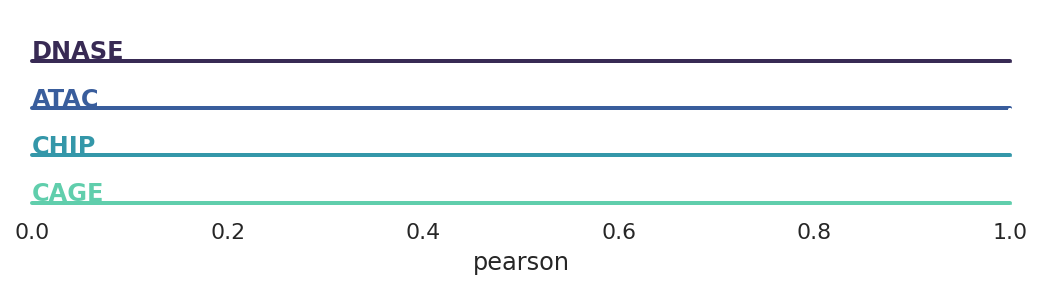

In [204]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="assay", hue="assay", aspect=15,  height = .5, palette="mako")
# Draw the densities in a few steps
g.map(sns.kdeplot, "pearson",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "pearson", clip_on=False, color="w", lw=2, bw_adjust=.5)
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

g.map(label, "pearson")
g.figure.subplots_adjust(hspace=0)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
g.set(xlim = (0,1))